In [150]:
import oracledb
import cx_Oracle
from datetime import datetime, timedelta, time, date
import numpy as np
from scipy.interpolate import splrep, splev
import csv
import pickle


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor


from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import IncrementalPCA


from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import median_absolute_error 

#### Функция чтения данных из БД

In [2]:
def read_temperature_from_db(start_date, finish_date):

    try:
        cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
    except:
        pass
    
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    /* SELECT to_char(DATAS, 'YYYY-MM-DD'), ADVANCE_TIME,  TEMP */
    SELECT DATAS, ADVANCE_TIME,  TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = 4
          AND ADVANCE_TIME between 0 and 48
          /*AND datas >= '01-08-2022'*/
          /*AND datas between '01-08-2022' and '31-12-2022'*/
          AND datas >= :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    start_date=start_date
    )
    
    date = None
    forecast_arr = []
    f_row = [] 
    for c in cursor_nwp:
        # Нова дата - создаем новую строку данных
        if date != c[0]:
            # Если дата пройдена, присоединить строку данных f_row к массиву forecast_arr
            if date:
                forecast_arr.append(f_row) 
            # Инициализируем следующую дату и строку данных
            date = c[0]       
            f_row = [None for _ in range(50)]
            f_row[0] = c[0] # Дату c[0] записать в позицию 0
        # В позицию списка, равную заблаговременности c[1] записать температуру c[2]
        f_row[c[1] + 1] = c[2]
    # Присоединить последнюю строку данных f_row к массиву forecast_arr
    forecast_arr.append(f_row)        
    # print(*forecast_arr, sep='\n')
    conn_nwp.close()
    
    
    conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
    cursor_gts = conn_gts.cursor()
    
    cursor_gts.execute(
    """
    SELECT DATE_OBS, TEMPDB
    FROM gts.synop
    WHERE 
      /*date_obs >= '01-08-2022'*/
      /* date_obs between '01-08-2022' and '31-12-2022' */
      date_obs >= :start_date
      AND station_id = '26850'
    """,
    start_date=start_date
    )
    
    gts_rows = cursor_gts.fetchall()
    # for c in gts_rows:
    #     print(c)
    
    conn_gts.close()
    
    
    # Формирование y - значений фактической температуры, соответствующих каждой дате на 48 часов вперед
    # Поиск каждой совпадающей строки по дате и сроку 00
    start = 0
    fact_arr = []
    forecast_X = []
    td48 = timedelta(hours=48)
    for f in forecast_arr:
        date_nwp = f[0]
        # Прервать выполнение, если от даты прогноза до текущего момента 
        # прошло менее или ровно 48 часов, т.к. не будет соответствующих фактических данных
        if datetime.today() - date_nwp <= td48:
            print(datetime.today() - date_nwp)
            print(f'Прервано - для даты {date_nwp} не хватит фактических данных!')
            break
        # print('NWP Date:', date_nwp)
        # print('GTS start:', start)
        for i, g in enumerate(gts_rows[start:]):
            if g[0] == f[0]: # Строка найдена
                # print(f[0])
                start += i
                forecast_X.append(f)
                break
        # Инициализировать строку данных для фактической температуры 17 значений
        g_row = [None for _ in range(18)]
        g_row[0] = g[0]
        # print('GTS Date:', g[0])
        for j in range(17):
            gts_date = gts_rows[start + j][0]
            gts_temperature = gts_rows[start + j][1]
            td = gts_date - date_nwp
            # print('Time delta for g_row:', td, 'Temper;', gts_temperature)
            # В пределах 48 часов
            if td <= td48:
                td_hours = int(td.days * 24 + td.seconds / 3600)
                # print('td_hours', td_hours)
                cell = td_hours // 3
                # print('cell', cell)
                g_row[cell + 1] = gts_temperature
            else:
                # start += i #!!!!
                print('BREAK!!!')
                break
        fact_arr.append(g_row)
        # print(g_row)
    
    # print(*forecast_arr, sep='\n')
    # print('Fact:')
    # print(*fact_arr, sep='\n')
    
    fact_y = fact_arr
    
    
    
    # Проверка на пропущенные значения (None)
    damaged_rows = set()
    
    for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
        
        if x[0] != y[0]:
            damaged_rows.add(i)
            print('Damaged dates:', x[0], y[0])
        
        damage_x = False
        for xi in x: 
            if xi is None:
                damage_x = True
                break
        if damage_x:
            damaged_rows.add(i)
            print('x', x)
        
        damage_y = False
        for yi in y: 
            if yi is None:
                damage_y = True
                break
        if damage_y:
            damaged_rows.add(i)
            print('y', y)
    
    damaged_rows = sorted(list(damaged_rows), reverse=True)
    print(damaged_rows)
    
    # Удаление строк с пропусками
    for i in damaged_rows:
        forecast_X.pop(i)
        fact_y.pop(i)

    return forecast_X, fact_y

In [3]:
forecast, fact = read_temperature_from_db('01-11-2022', '')

1 day, 10:23:34.167404
Прервано - для даты 2024-01-07 00:00:00 не хватит фактических данных!
x [datetime.datetime(2022, 11, 5, 0, 0), 4.638, 4.118, 3.396, 2.756, 1.855, 0.817, 0.668, 1.091, 2.043, 3.152, 4.045, 4.577, 4.541, 4.278, 3.244, 2.414, 1.979, 1.642, 1.631, 1.587, 1.535, 1.776, 2.175, 2.486, 2.702, 2.911, 3.105, 3.308, 3.55, 3.769, 4.043, 4.34, 4.66, 4.954, 5.217, 5.46, 5.622, 5.774, 5.864, 5.897, 5.978, 6.109, 6.303, 6.368, 6.331, 6.58, None, 6.754, 6.694]
x [datetime.datetime(2022, 11, 7, 0, 0), 4.293, 4.187, 4.182, 4.581, 4.85, 5.203, 5.301, 5.838, 6.525, 6.703, 6.846, 7.786, 8.512, None, 8.476, 8.345, 8.393, 8.356, 8.256, 8.161, 8.123, 7.983, 7.41, 6.643, 5.99, 5.361, 5.144, 5.378, 5.498, 5.401, 5.217, 5.913, 6.881, 7.712, 7.816, 7.75, 7.756, 7.926, 7.894, 7.805, 7.803, 7.862, 7.685, 7.696, 7.865, 7.862, 7.844, 7.939, 7.097]
x [datetime.datetime(2022, 12, 23, 0, 0), 1.255, 1.178, 1.157, 1.155, 1.09, 1.152, 1.127, 1.014, 0.988, None, 0.932, 0.925, 0.937, 0.932, 0.851, 1.016

#### Функция записи датасетов в файлы CSV

In [104]:
def write_csv(forecast, fact, forecast_model, z=48, append=True):
    mode = 'at' if append else 'wt'
    # Запись прогноза
    forecast_header = ['date_term'] + [f'z_{x}' for x in range(z + 1)]
    with open(f'data/forecast_{forecast_model}.csv', mode, newline='') as f_forecast:
        forecast_writer = csv.writer(f_forecast, delimiter=';')
        if mode == 'wt':
            forecast_writer.writerow(forecast_header)
        forecast_writer.writerows(forecast)
    # Запись факта
    fact_header = ['date'] + [f't_{x % 24}' for x in range(0, z + 1, 3)]
    with open(f'data/fact.csv', mode, newline='') as f_fact:
        fact_writer = csv.writer(f_fact, delimiter=';')
        if mode == 'wt':
            fact_writer.writerow(fact_header)
        fact_writer.writerows(fact)

    # Запись файла с датой последних данных в датасетах
    date_time = forecast[-1][0]
    write_last_date_file(date_time)

#### Функция записи файла с датой последних данных в датасетах

In [78]:
def write_last_date_file(date_time):
    with open(f'data/last_date.txt', 'wt') as f:
        f.write(str(date_time))

#### Функция чтения файла с датой последних данных в датасетах

In [105]:
def read_last_date_file():
    with open(f'data/last_date.txt', 'rt') as f:
        date_time_str = f.readline()
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    return date_time

In [90]:
read_last_date_file()

datetime.datetime(2024, 1, 6, 0, 0)

## Функция создания на диске датасетов forecast, fact

In [79]:
def create_datasets(start_date, forecast_model, z=48):
    forecast, fact = read_temperature_from_db(start_date, '')
    write_csv(forecast, fact, forecast_model, z=z, append=False)

In [142]:
create_datasets('01-11-2022', 'gfs', z=48)

1 day, 17:28:09.833848
Прервано - для даты 2024-01-07 00:00:00 не хватит фактических данных!
x [datetime.datetime(2022, 11, 5, 0, 0), 4.638, 4.118, 3.396, 2.756, 1.855, 0.817, 0.668, 1.091, 2.043, 3.152, 4.045, 4.577, 4.541, 4.278, 3.244, 2.414, 1.979, 1.642, 1.631, 1.587, 1.535, 1.776, 2.175, 2.486, 2.702, 2.911, 3.105, 3.308, 3.55, 3.769, 4.043, 4.34, 4.66, 4.954, 5.217, 5.46, 5.622, 5.774, 5.864, 5.897, 5.978, 6.109, 6.303, 6.368, 6.331, 6.58, None, 6.754, 6.694]
x [datetime.datetime(2022, 11, 7, 0, 0), 4.293, 4.187, 4.182, 4.581, 4.85, 5.203, 5.301, 5.838, 6.525, 6.703, 6.846, 7.786, 8.512, None, 8.476, 8.345, 8.393, 8.356, 8.256, 8.161, 8.123, 7.983, 7.41, 6.643, 5.99, 5.361, 5.144, 5.378, 5.498, 5.401, 5.217, 5.913, 6.881, 7.712, 7.816, 7.75, 7.756, 7.926, 7.894, 7.805, 7.803, 7.862, 7.685, 7.696, 7.865, 7.862, 7.844, 7.939, 7.097]
x [datetime.datetime(2022, 12, 23, 0, 0), 1.255, 1.178, 1.157, 1.155, 1.09, 1.152, 1.127, 1.014, 0.988, None, 0.932, 0.925, 0.937, 0.932, 0.851, 1.016

## Функция обновления датасетов новыми данными

In [112]:
def update_datasets(forecast_model, z=48):
    update_date_time = read_last_date_file() + timedelta(hours=24)
    date_str = update_date_time.strftime('%d-%m-%Y')    
    forecast, fact = read_temperature_from_db(date_str, '')
    if forecast:
        write_csv(forecast, fact, forecast_model, z=z, append=True)
    else:
        print(f'Прервано - для даты {update_date_time} не хватит фактических данных!')

In [113]:
update_datasets('gfs', z=48)

1 day, 14:51:36.147747
Прервано - для даты 2024-01-07 00:00:00 не хватит фактических данных!
[]
Прервано - для даты 2024-01-07 00:00:00 не хватит фактических данных!


#### Функция чтения датасетов из csv файлов

In [143]:
def read_datasets(forecast_model):
    forecast = []
    with open(f'data/forecast_{forecast_model}.csv', 'rt', newline='') as f_forecast:
        forecast_reader = csv.reader(f_forecast, delimiter=';')
        forecast_header = next(forecast_reader)
        for row in forecast_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    r.append(datetime.strptime(e, '%Y-%m-%d %H:%M:%S'))
                else:
                    r.append(float(e))
            forecast.append(r)
            
    fact = []
    with open('data/fact.csv', 'rt', newline='') as f_fact:
        fact_reader = csv.reader(f_fact, delimiter=';')
        fact_header = next(fact_reader)
        for row in fact_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    r.append(datetime.strptime(e, '%Y-%m-%d %H:%M:%S'))
                else:
                    r.append(float(e))
            fact.append(r)

    return forecast, fact

In [144]:
forecast, fact = read_datasets('gfs')
print(forecast[-1])
print(fact[-1])

[datetime.datetime(2024, 1, 6, 0, 0), -8.31, -9.065, -9.506, -9.948, -10.522, -11.134, -11.505, -11.093, -9.509, -8.594, -8.332, -8.352, -8.74, -9.907, -11.953, -12.769, -13.373, -14.027, -14.421, -14.838, -15.124, -15.554, -15.756, -15.815, -15.843, -15.897, -16.161, -16.078, -16.048, -16.113, -16.189, -16.209, -15.701, -14.911, -14.224, -13.661, -13.4, -13.698, -14.436, -14.934, -14.955, -14.959, -14.923, -14.829, -14.833, -14.76, -14.699, -14.724, -14.666]
[datetime.datetime(2024, 1, 6, 0, 0), -6.8, -7.8, -6.9, -6.4, -6.5, -7.9, -10.0, -15.2, -19.4, -20.9, -19.6, -18.2, -15.9, -17.3, -18.3, -19.2, -19.4]


#### Функция подготовки X и y

In [4]:
def get_xy(foreast, fact):
    X = np.array([x[1:] for x in forecast])
    y = np.array([y[1:] for y in fact])
    print(X.shape)
    print(y.shape)
    return X, y

#### Функция интерполяции строк целевых значений y

In [6]:
def interpolate_y_rows(arr, knots, degree=2):
    x = np.linspace(0, arr.shape[1], arr.shape[1])
    x_knots = np.linspace(0, arr.shape[1], knots)
    arr_new = []
    for y in arr:
        x_spl = splrep(x, y, k=degree)
        y2 = splev(x_knots, x_spl)
        arr_new.append(y2)

    
    return np.array(arr_new)


#### Функция аугментации данных

In [7]:
def augment_data(x_data, y_data, knots, degree=2):
    data_len = len(y_data)
    prior_points = np.linspace(0, data_len, data_len)
    
    xy = []
    for z in (x_data, y_data):
        z_splitted = np.hsplit(z, z.shape[1])
        #print(x_splitted)
        z_list = []
        for arr in z_splitted:
            z_spl = splrep(prior_points, arr, k=degree)
            z_points_n = np.linspace(0, data_len, knots)
            z_col_augmented = splev(z_points_n, z_spl)
            z_list.append(z_col_augmented)
        z_augmented = np.array(z_list).T
        xy.append(z_augmented)
    
    x_result, y_result = xy
    return x_result, y_result

#### Функция получения трансформеров данных

In [9]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

## Функция оценки моделей

In [145]:
def evaluate_models():

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets('gfs')
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    plt.plot(y_points_prior, y_prior[-13], 'o')
    plt.plot(y_points, y[-13])
    plt.legend()
    plt.show()
    
    
    # Аугментация данных
    X, y = augment_data(X_prior, y, 3000, degree=1)
    print(X.shape, y.shape)
    
    
    # Разделение на тренировочный и тестовый набор
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    print(X_train)
    
    # Условия масштабирования
    scaler_x = 'normal-yj-st'
    scaler_y = None
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 7)
    # model = RidgeCV()
    model = ExtraTreesRegressor(n_estimators=150, random_state=0)
    # model = RandomForestRegressor(n_estimators=150, random_state=0)
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0)
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 7, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu')
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    decomposition = PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized') #!!
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
    
    # Обучение моделей
    regr.fit(X_train, y_train)
    
    # Запись модели в файл
    
    # Оценка качества модели
    predicted = regr.predict(X_test)
    r2 = regr.score(X_test, y_test)
    print(r2)
    _ = quality(y_test, predicted)

    # Оценка качества исходного прогноза
    _ = quality(X_train, y_train)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(358, 49)
(358, 17)


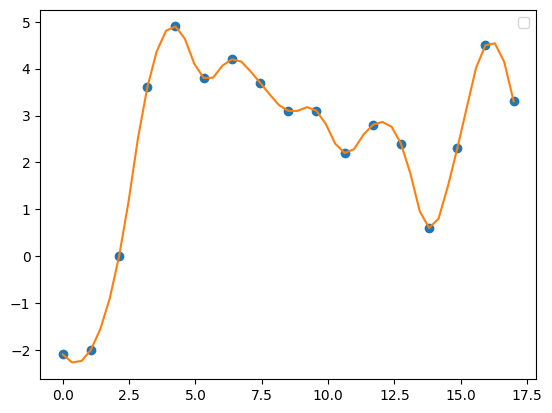

(3000, 49) (3000, 49)
[[  0.47664288   0.73944281   1.54698333 ...  -1.48507903  -1.57075859
   -1.51834912]
 [ -3.31407703  -3.20665522  -3.42065689 ...  -4.23076392  -4.44921507
   -4.462999  ]
 [ -2.50327609  -2.76086362  -2.99753451 ... -12.92124975 -13.38352818
  -13.65094598]
 ...
 [  0.61674225   0.42999      0.46638613 ...   4.1265952    3.48283661
    3.06462121]
 [  8.24074558   8.05834345   7.97037246 ...   7.86877459   7.35688663
    7.03730944]
 [ -3.41807503  -3.5651944   -3.72635579 ...  -0.53144648  -0.69653718
   -0.91466289]]
0.9969403521377459
r2_score: 0.9969403521377459
mean_absolute_error: 0.2963063869062912
mean_squared_error: 0.24230825811511172
median_absolute_error: 0.17299528533793043
r2_score: 0.9581319957564763
mean_absolute_error: 1.3691624659168706
mean_squared_error: 3.40955925297871
median_absolute_error: 1.0556818195139435


In [146]:
evaluate_models()

#### Функция записи моделей в файл

In [161]:
def write_model(model_obj, forecast_model, date_str):
    with open(f'data/{forecast_model}-{date_str}.bin', 'wb') as f:
        model_bin = pickle.dump(model_obj, f, pickle.HIGHEST_PROTOCOL)

## Функция обучения моделей и записи в виде файлов

In [162]:
def train_models(forecast_model):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets(forecast_model)
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    plt.plot(y_points_prior, y_prior[-13], 'o')
    plt.plot(y_points, y[-13])
    plt.legend()
    plt.show()
    
    
    # Аугментация данных
    X, y = augment_data(X_prior, y, 3000, degree=1)
    print(X.shape, y.shape)
    
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    # print(X_train)
    
    # Условия масштабирования
    scaler_x = 'normal-yj-st'
    scaler_y = None
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 7)
    # model = RidgeCV()
    model = ExtraTreesRegressor(n_estimators=150, random_state=0)
    # model = RandomForestRegressor(n_estimators=150, random_state=0)
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0)
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 7, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu')
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    decomposition = PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized') #!!
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
    
    # Обучение моделей
    regr.fit(X, y)
    
    # Запись модели в файл
    date_str = datetime.strftime(forecast[-1][0], '%Y-%m-%d_%H')
    write_model(regr, forecast_model, date_str)
    
    # Оценка качества модели
    predicted = regr.predict(X)
    r2 = regr.score(X, y)
    print(r2)
    _ = quality(y, predicted)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(358, 49)
(358, 17)


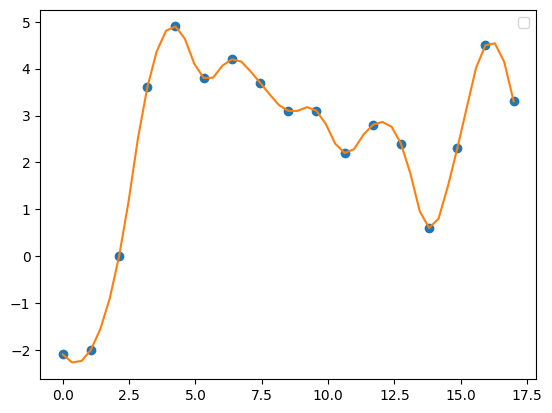

(3000, 49) (3000, 49)
1.0
r2_score: 1.0
mean_absolute_error: 1.4495221500210888e-14
mean_squared_error: 5.014702137780636e-28
median_absolute_error: 8.109159602313134e-15


In [163]:
train_models('gfs')

In [15]:
def quality(y_true, predicted):
    q = {}
    q["r2_score"] = r2_score(y_true, predicted) #q_max_error 
    # q[max_error] = max_error(y_true, predicted) #q_max_error 
    q["mean_absolute_error"] = mean_absolute_error(y_true, predicted) #q_mean_absolute_error
    q["mean_squared_error"] = mean_squared_error(y_true, predicted) #q_mean_squared_error 
    # q[mean_squared_log_error] = mean_squared_log_error(y_true, predicted) #q_mean_squared_log_error 
    q["median_absolute_error"] = median_absolute_error(y_true, predicted) #q_median_absolute_error 

    print(
    f'r2_score: {q["r2_score"]}',
    # f'max_error: {q[1]}',
    f'mean_absolute_error: {q["mean_absolute_error"]}',
    f'mean_squared_error: {q["mean_squared_error"]}',
    # f'mean_squared_log_error: {q[4]}',
    f'median_absolute_error: {q["median_absolute_error"]}',
    sep='\n')
    
    return q


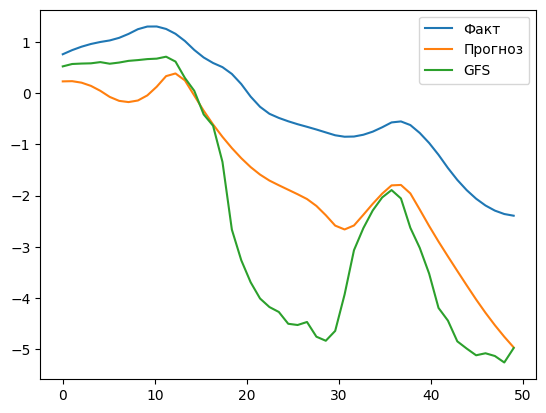

In [26]:
y_points = np.linspace(0, y.shape[1], y.shape[1])
# y_points_int = np.linspace(0, y.shape[1], y_int.shape[1])
x_points = np.linspace(0, y.shape[1], X.shape[1])

plt.plot(y_points, y_test[-25], label='Факт')
plt.plot(y_points, predicted[-25], label='Прогноз')
plt.plot(x_points, X_test[-25], label='GFS')
plt.legend()
plt.show()

<Axes: >

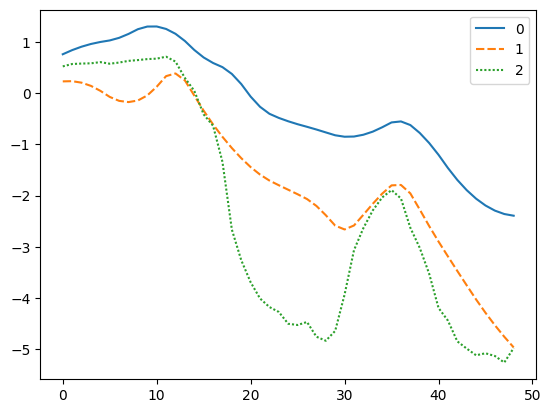

In [25]:
# test_data = np.vstack((y_test[20], predicted[20])).T
test_data = np.vstack((y_test[-25], predicted[-25], X_test[-25])).T
# test_data = np.vstack((y_test[-1], y_test[-2], X_test[-1][::3])).T
sns.lineplot(data=test_data)

In [20]:
arr = np.array(
   [[0], 
    [2],
    [1], 
    [4], 
    [-2], 
    [1], 
    [-4]]
)

spt = SplineTransformer(n_knots=13)
arr2 = spt.fit_transform(arr)
print(arr2)

[[0.         0.         0.         0.         0.         0.
  0.16666667 0.66666667 0.16666667 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.16666667 0.66666667 0.16666667
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.02083333 0.47916667 0.47916667 0.02083333 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.16666667 0.66666667 0.16666667]
 [0.         0.         0.         0.16666667 0.66666667 0.16666667
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.02083333 0.47916667 0.47916667 0.02083333 0.
  0.         0.         0.        ]
 [0.16666667 0.66666667 0.16666667 0.         0.